### Working notebook for generating weekly data visualisations and other EDA

In [1]:
# Change the backend to enable loading of emoji font
# import matplotlib, mplcairo
# print('Default backend: ' + matplotlib.get_backend()) 
# matplotlib.use("module://mplcairo.macosx")
# print('Backend is now ' + matplotlib.get_backend())


Default backend: module://ipykernel.pylab.backend_inline
Backend is now module://mplcairo.macosx


In [1]:
import os
import sys
sys.path.append('../sharechat-scraper')
import pymongo
from pymongo import MongoClient
from s3_mongo_helper import initialize_mongo
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import re
from collections import Counter
from dotenv import load_dotenv
load_dotenv()
%matplotlib inline

In [2]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import base64
import random
import plotly
import wordcloud
from wordcloud import WordCloud
from os import path
import nltk
from nltk.tokenize import regexp_tokenize

In [3]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [4]:
coll = initialize_mongo()

In [5]:
coll.count_documents({})

373519

In [941]:
end = datetime.utcnow() 
start = end - timedelta(days=7)
cursor = coll.find({"scraped_date": {'$gte':start,'$lt':end}})

In [942]:
df = pd.DataFrame.from_records(cursor)

In [943]:
len(df)

25763

In [127]:
df.head(1)


,_id,bucket_id,bucket_name,caption,comments,comments_t+1,comments_t+2,comments_t+3,comments_t+34,comments_t+36,comments_t+37,comments_t+4,comments_t+5,external_shares,external_shares_t+1,external_shares_t+2,external_shares_t+3,external_shares_t+34,external_shares_t+36,external_shares_t+37,external_shares_t+4,external_shares_t+5,filename,language,likes,likes_t+1,likes_t+2,likes_t+3,likes_t+34,likes_t+36,likes_t+37,likes_t+4,likes_t+5,media_link,media_type,post_permalink,profile_page,reposts,reposts_t+1,reposts_t+2,reposts_t+3,reposts_t+34,reposts_t+36,reposts_t+37,reposts_t+4,reposts_t+5,s3_url,scraped_date,scraper_type,tag_category,tag_creation,tag_genre,tag_id,tag_members,tag_name,tag_rejects,tag_reports,tag_translation,text,thumbnail,timestamp,verified,views,views_t+1,views_t+2,views_t+3,views_t+34,views_t+36,views_t+37,views_t+4,views_t+5
0,5f443c7b93df35ae7b72f9c8,125,ख़बरें और राजनीति,#📰 समाचार एवं न्यूज़ पेपर क्लिप #Crime Against Men #👩‍🎨WhatsApp प्रोफाइल DP,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90f1dd5b-83ca-4169-a84e-5c8d6f8e907a,Hindi,1206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://cdn.sharechat.com/समाचारएवंन्यूज़पेपरक्लिप_3047261a_1598150606812_cmprsd_40.jpg,image,https://sharechat.com/post/q5KJbb7,https://sharechat.com/profile/78266438,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://s3.ap-south-1.amazonaws.com/sharechat-scraper.tattle.co.in/90f1dd5b-83ca-4169-a84e-5c8d6f8e907a.jpg,2020-08-24 21:43:25.666,trending,Generic,1514808000,News,Kyweq,24009,📰 समाचार एवं न्यूज़ पेपर क्लिप,2723.0,55.0,📰 News and newspaper clip,None,https://s3.ap-south-1.amazonaws.com/sharechat-scraper.tattle.co.in/90f1dd5b-83ca-4169-a84e-5c8d6f8e907a.jpg,2020-08-23 02:43:27,0,93205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [905]:
df.columns

Index(['_id', 'bucket_id', 'bucket_name', 'caption', 'comments',
       'external_shares', 'filename', 'language', 'likes', 'media_link',
       'media_type', 'post_permalink', 'profile_page', 'reposts', 's3_url',
       'scraped_date', 'scraper_type', 'tag_category', 'tag_creation',
       'tag_genre', 'tag_id', 'tag_members', 'tag_name', 'tag_rejects',
       'tag_reports', 'tag_translation', 'text', 'thumbnail', 'timestamp',
       'verified', 'views'],
      dtype='object')

In [130]:
# Drop redundant columns
# df.drop(["thumbnail", "_id", "filename",'views_t+34', 'views_t+36', 'views_t+37','reposts_t+34',
#        'reposts_t+36', 'reposts_t+37','likes_t+34', 'likes_t+36', 'likes_t+37','external_shares_t+34', 'external_shares_t+36',
#        'external_shares_t+37','comments_t+34',
#        'comments_t+36', 'comments_t+37'], axis=1, inplace=True)

In [132]:
# Convert virality metrics columns to numeric type
df[["comments", "likes", "reposts", "external_shares", "views", "verified"]] = df[["comments", "likes", "reposts", "external_shares", "views", "verified"]].apply(pd.to_numeric, errors='coerce')

## Verified vs non verified

In [910]:
df["verified"].value_counts()

0    6743
1    397 
1    60  
0    14  
4    4   
Name: verified, dtype: int64

In [911]:
total = (df["verified"].value_counts()[0] + df["verified"].value_counts()[1])
verif = (df["verified"].value_counts()[1] / total) * 100
print(verif)

5.560224089635854


In [135]:
# Remove bad data
verif_df = df[df["verified"] != 4]

In [ ]:
verif_df["verified"]=verif_df["verified"].astype("category")

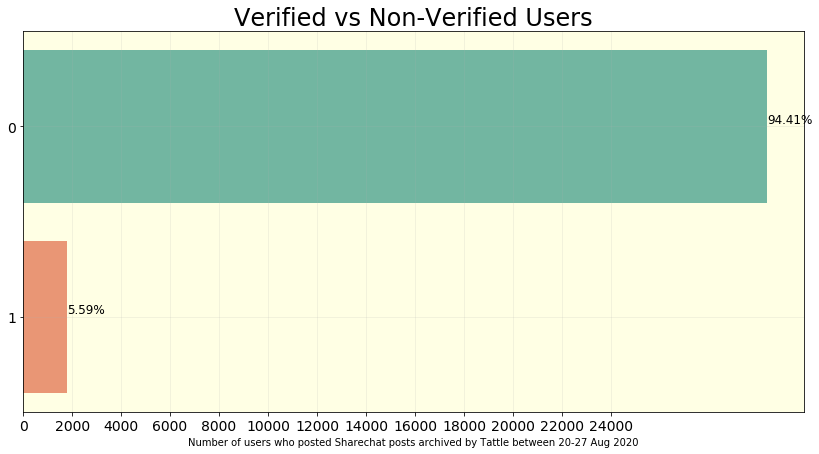

In [137]:
plt.figure(figsize=(14,7))
ax = sns.countplot(y = "verified", data = verif_df, order = verif_df["verified"].value_counts().index, palette = "Set2");
ax.set_alpha(0.8)
ax.set_title("Verified vs Non-Verified Users", fontsize=24)
ax.set_xlabel("Number of users who posted Sharechat posts archived by Tattle between 20-27 Aug 2020", fontsize=10);
ax.set_ylabel("");
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax.set_xticks(range(0, 25000, 2000))
ax.set_facecolor('xkcd:off white')
ax.grid(alpha = 0.2)

# Add percentages to individual bars
totals = []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=12,
color='black')

plt.show()

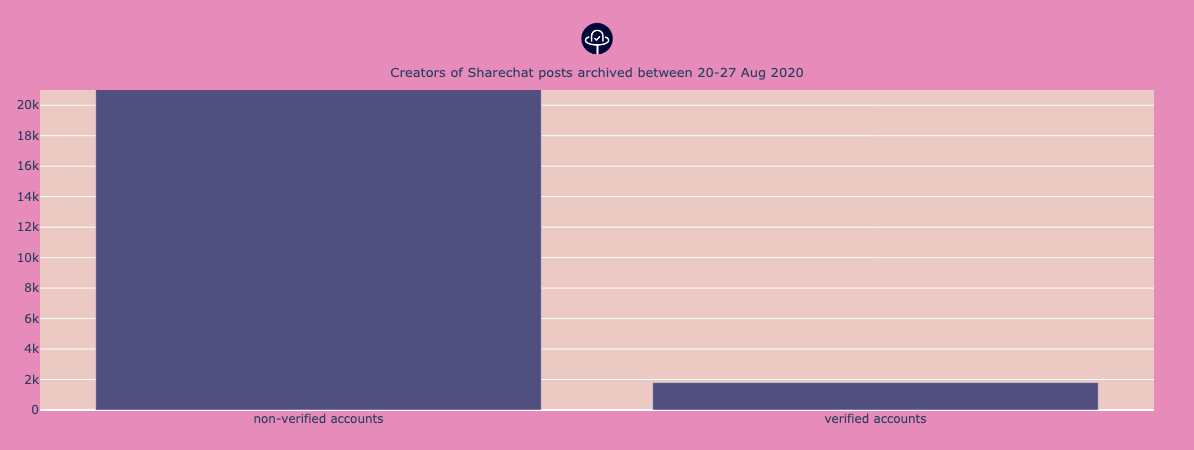

In [154]:
fig = go.Figure(
    data=[go.Bar(x=["non-verified accounts", "verified accounts"], 
                y=verif_df["verified"].value_counts())],
    layout=go.Layout(
        title=go.layout.Title(text="Creators of Sharechat posts archived between 20-27 Aug 2020",
                              x=0.5,
                              y=0.85,
                              yanchor="top",
                              font={"size":13}),
        plot_bgcolor="#EDC9C4",
        paper_bgcolor="#E68BBA",
       colorway=["#514E80"],
        width=500,
        height=450,
        autosize=False,
        margin={"l":40, "r":40, "t":90, "b":40}
    )
)
fig.update_yaxes(range=[0,21000], dtick=2000)
fig.add_layout_image(dict(
                         source="https://raw.githubusercontent.com/tattle-made/sharechat-scraper/master/favicon_tattle_monogram_dark.png",
                         xref="paper",
                         yref="paper",
                         x=0.5,
                         y=1.11,
                         sizex=0.1, 
                         sizey=0.1,
                         xanchor="center", 
                         yanchor="bottom"))

fig.show()

In [47]:
# from plotly.offline import plot
# plot(fig)

'temp-plot.html'

In [48]:
fig.write_image("sample.png", height=450,width=500,scale=10)

## Temporary tags

In [912]:
df["tag_category"].value_counts()

Generic               2401
Temporary             2107
Niche                 1783
Community Campaign    367 
Regional              307 
Special               164 
Alliance Campaign     78  
Tool Bug              11  
Name: tag_category, dtype: int64

In [913]:
df[df["tag_category"] == "Temporary"]["tag_translation"].value_counts()[:5]

Thank You maharashtra police    91
Daily news update               87
breaking news                   86
thank you doctor/nurse          84
Maharashra rain updates         84
Name: tag_translation, dtype: int64

## Most liked

In [916]:
most_liked = df.sort_values(by="likes", ascending=False)[:5]

In [917]:
most_liked["post_permalink"]

6824    https://sharechat.com/post/qOr3zwG
5964    https://sharechat.com/post/rbgvnBw
4561    https://sharechat.com/post/pq9a38v
5592    https://sharechat.com/post/pg8D5da
5984    https://sharechat.com/post/qqPxb5K
Name: post_permalink, dtype: object

## Most shared

In [914]:
most_shared = df.sort_values(by="external_shares", ascending=False)[:5]

In [915]:
most_shared["post_permalink"]

5826    https://sharechat.com/post/q5vby5l 
4618    https://sharechat.com/post/Nn4bVXD 
5863    https://sharechat.com/post/pkkR7wre
3911    https://sharechat.com/post/pkPe7E6g
4546    https://sharechat.com/post/pkjkG4Ka
Name: post_permalink, dtype: object

## Highest virality diff

In [119]:
df["likes_diff"] = df["likes_t+5"] - df["likes"]
df["shares_diff"] = df["external_shares_t+5"] - df["external_shares"]

In [126]:
df.sort_values(by="likes_diff", ascending=False)[:1]

,bucket_id,bucket_name,caption,comments,comments_t+1,comments_t+2,comments_t+3,comments_t+4,comments_t+5,external_shares,external_shares_t+1,external_shares_t+2,external_shares_t+3,external_shares_t+4,external_shares_t+5,language,likes,likes_t+1,likes_t+2,likes_t+3,likes_t+4,likes_t+5,media_link,media_type,post_permalink,profile_page,reposts,reposts_t+1,reposts_t+2,reposts_t+3,reposts_t+4,reposts_t+5,s3_url,scraped_date,scraper_type,tag_category,tag_creation,tag_genre,tag_id,tag_members,tag_name,tag_rejects,tag_reports,tag_translation,text,timestamp,verified,views,views_t+1,views_t+2,views_t+3,views_t+4,views_t+5,likes_diff,shares_diff
3139,515,समाचार,jay Rajasthan #🌁 राजस्थान के पर्यटन स्थल #🏘 म्हारो राजस्थान🙏 #👆 राजस्थान री धरोहर #🗞 राजस्थान समाचार,0,NaN,0.0,NaN,0.0,0.0,17,NaN,52.0,NaN,97.0,120.0,Rajasthani,30,NaN,191.0,NaN,330.0,399.0,https://cdn.sharechat.com/17b34d9c_1598047731114_c_v__a1f7ff5f-b6b0-40f7-8970-eac6c23a3137.mp4,video,https://sharechat.com/post/qkMNxDA,https://sharechat.com/profile/552377616,0,NaN,0.0,NaN,0.0,0.0,https://s3.ap-south-1.amazonaws.com/sharechat-scraper.tattle.co.in/45769f27-6449-4212-b4e7-f9b6e0ffde6b.mp4,2020-08-22 21:59:05.126,fresh,Generic,1521196007,News,B0q8R,5238,🗞 राजस्थान समाचार,66.0,43.0,Rajatshan News,None,2020-08-21 22:08:52,0,1051,NaN,6502.0,NaN,12471.0,15296.0,369.0,103.0


## Buckets

In [219]:
bucket_df['bucket_name'] = np.where(bucket_df['bucket_name'] == "देश प्रेमी", "देश प्रेम ", bucket_df['bucket_name'])

In [320]:
bucket_df["bucket_name"].unique()

array(['ख़बरें और राजनीति', 'कोरोना वायरस', 'स्वास्थ्य', 'देश प्रेम ',
       'समाचार', 'সাবধান : করোনা ভাইরাস', 'নিউস ', 'টাটকা Trend😎'],
      dtype=object)

In [321]:
bucket_df[bucket_df["bucket_name"]=="कोरोना वायरस"]["language"].unique()

array(['Hindi', 'Rajasthani', 'Telugu', 'Marathi'], dtype=object)

In [362]:
bucket_df["bucket_name"].value_counts().index

Index(['ख़बरें और राजनीति', 'देश प्रेम ', 'स्वास्थ्य', 'টাটকা Trend😎', 'নিউস ',
       'कोरोना वायरस', 'সাবধান : করোনা ভাইরাস', 'समाचार'],
      dtype='object')

In [643]:
buckets=['ख़बरें और राजनीति', 'देश प्रेम ', 'स्वास्थ्य', 'টাটকা Trend😎', 'নিউস ',
       'कोरोना वायरस', 'সাবধান : করোনা ভাইরাস', 'समाचार']

In [644]:
english_buckets= ["News & Politics", "Patriotism", "Health", "Fresh Trends", "News", "Coronavirus", "Caution: Coronavirus", "News"]

In [645]:
buckets_dict=dict(zip(buckets,english_buckets))

In [646]:
buckets_dict

{'ख़बरें और राजनीति': 'News & Politics',
 'देश प्रेम ': 'Patriotism',
 'स्वास्थ्य': 'Health',
 'টাটকা Trend😎': 'Fresh Trends',
 'নিউস ': 'News',
 'कोरोना वायरस': 'Coronavirus',
 'সাবধান : করোনা ভাইরাস': 'Caution: Coronavirus',
 'समाचार': 'News'}

In [885]:
xticks=[]
for k,v in buckets_dict.items():
    xticks.append(k+"<br>"+"("+v+")")

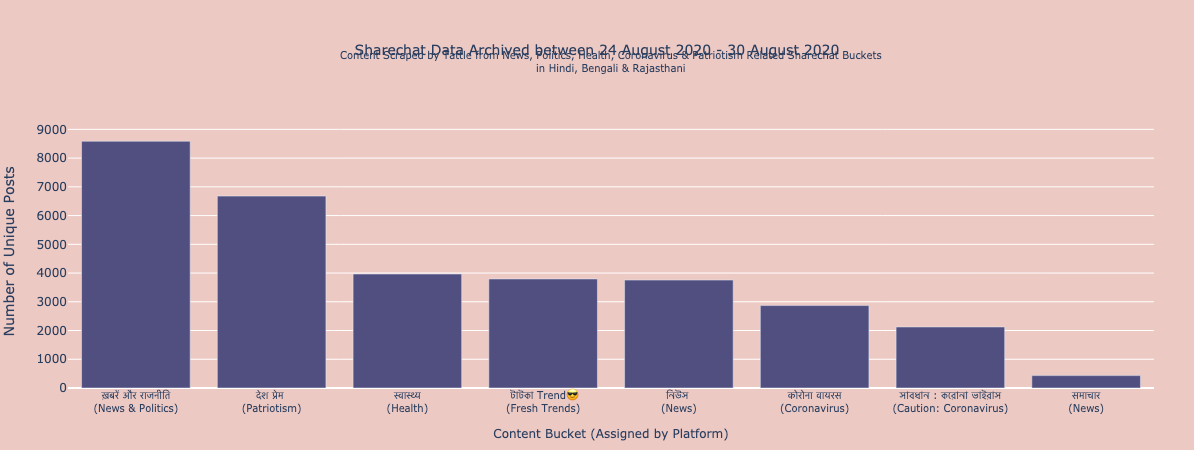

In [886]:
fig = go.Figure(
    data=[go.Bar(x=xticks,
        y=bucket_df["bucket_name"].value_counts())],
    layout=go.Layout(
        title=go.layout.Title(text="Sharechat Data Archived between 24 August 2020 - 30 August 2020",
                              x=0.5,
                              y=0.9,
                              yanchor="top",
                              font={"size":14}),
        plot_bgcolor="#EDC9C4",
       paper_bgcolor="#EDC9C4",
        colorway=["#514E80"],
        width=600,
        height=450,
        autosize=False,
        margin={"l":40, "r":40, "t":115, "b":40}
    )
)
fig.update_yaxes(range=[0,9500], dtick=1000)

fig.add_layout_image(dict(
                         source="https://raw.githubusercontent.com/tattle-made/sharechat-scraper/master/logo_name_blue.png",
                         xref="paper",
                         yref="paper",
                         x=-0.12,
                         y=-0.52,
                         sizex=0.11, 
                         sizey=0.11,
                         xanchor="left", 
                         yanchor="bottom"))
fig.update_layout(yaxis_title="Number of Unique Posts", xaxis_title={"text":"Content Bucket (Assigned by Platform)",
                                                             "font":{"size":12}})

fig.update_xaxes(tickfont=dict(size=10))

fig.update_layout(annotations=[
       go.layout.Annotation(
           xref="paper",
           yref="paper",
            showarrow=False,
            text="Content Scraped by Tattle from News, Politics, Health, Coronavirus & Patriotism Related Sharechat Buckets<br>"+"in Hindi, Bengali & Rajasthani",
            x=0.5,
            y=1.25,
            font=dict(
                size=10,
            )
        )])

fig.add_annotation(
           xref="paper",
           yref="paper",
            text="tattle.co.in",
            showarrow=False,
            x=1.07,
            y=-0.52,
            font=dict(
                size=9,
            ))

fig.show()

In [887]:
fig.write_image("buckets31082020.png", width=600,height=450,scale=10)

## Popular

In [455]:
pop = df[df["external_shares"] > 500]

In [456]:
len(df)

32200

In [457]:
len(pop)

237

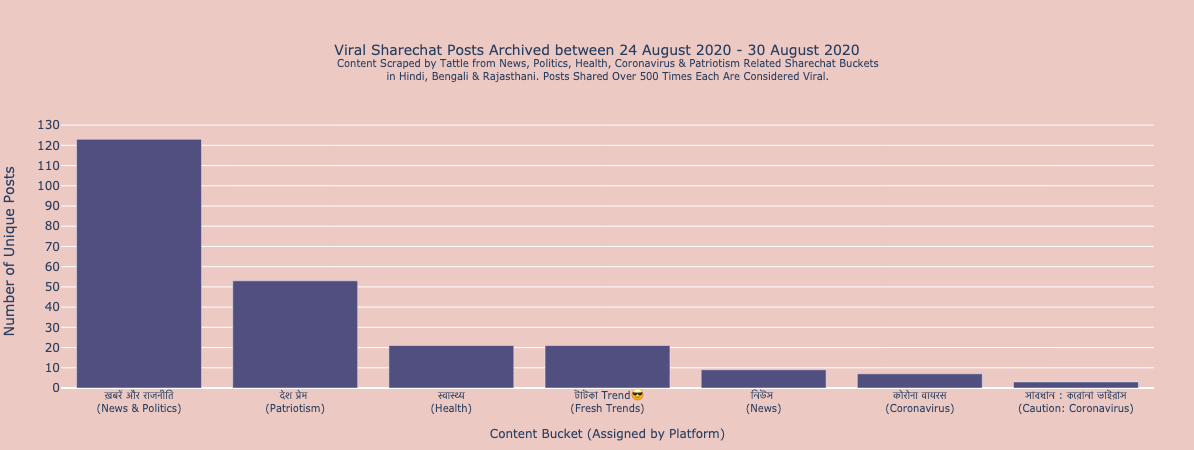

In [874]:
fig = go.Figure(
    data=[go.Bar(x=xticks,
        y=pop["bucket_name"].value_counts())],
    layout=go.Layout(
        title=go.layout.Title(text="Viral Sharechat Posts Archived between 24 August 2020 - 30 August 2020",
                              x=0.5,
                              y=0.9,
                              yanchor="top",
                              font={"size":14}),
        plot_bgcolor="#EDC9C4",
        paper_bgcolor="#EDC9C4",
        colorway=["#514E80"],
        width=600,
        height=450,
        autosize=False,
        margin={"l":40, "r":40, "t":115, "b":40}
    )
)
fig.update_yaxes(range=[0,135], dtick=10)

fig.add_layout_image(dict(
                         source="https://raw.githubusercontent.com/tattle-made/sharechat-scraper/master/logo_name_blue.png",
                         xref="paper",
                         yref="paper",
                         x=-0.12,
                         y=-0.52,
                         sizex=0.1, 
                         sizey=0.1,
                         xanchor="left", 
                         yanchor="bottom"))
fig.update_layout(yaxis_title="Number of Unique Posts", xaxis_title={"text":"Content Bucket (Assigned by Platform)",
                                                             "font":{"size":12}})

fig.update_xaxes(tickfont=dict(size=10))


fig.update_layout(annotations=[
       go.layout.Annotation(
           xref="paper",
           yref="paper",
            showarrow=False,
            text="Content Scraped by Tattle from News, Politics, Health, Coronavirus & Patriotism Related Sharechat Buckets<br>"+"in Hindi, Bengali & Rajasthani. Posts Shared Over 500 Times Each Are Considered Viral.",
            x=0.5,
            y=1.22,
            font=dict(
                size=10,
            )
        )])

fig.add_annotation(
           xref="paper",
           yref="paper",
            text="tattle.co.in",
            showarrow=False,
            x=1.17,
            y=-0.52,
            font=dict(
                size=9,
            ))

fig.show()

In [875]:
fig.write_image("viralbuckets31082020.png", width=600,height=450,scale=10)

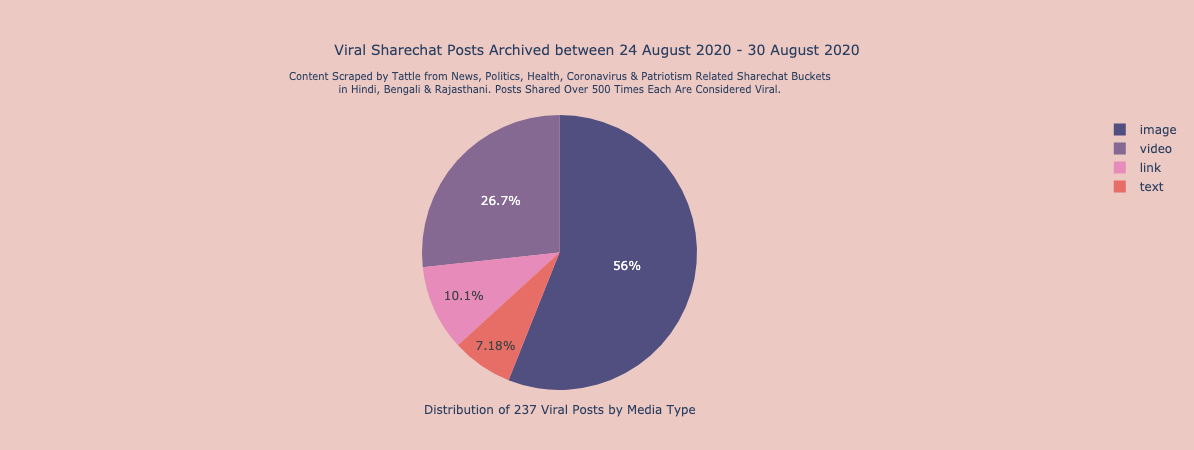

In [918]:
fig = go.Figure(
    data=[go.Pie(labels=pop["media_type"].value_counts().index, values=pop["media_type"].value_counts())],
        layout=go.Layout(
        title=go.layout.Title(text="Viral Sharechat Posts Archived between 24 August 2020 - 30 August 2020",
                              x=0.5,
                              y=0.9,
                              yanchor="top",
                              font={"size":14}),
        plot_bgcolor="#EDC9C4",
        paper_bgcolor="#EDC9C4",
        colorway=["#514E80", "#856993", "#E68BBA", "#E76D67"],
        width=600,
        height=450,
        autosize=False,
        margin={"l":40, "r":40, "t":115, "b":60}
    )
)
fig.update_yaxes(range=[0,205], dtick=10)

fig.add_layout_image(dict(
                         source="https://raw.githubusercontent.com/tattle-made/sharechat-scraper/master/logo_name_blue.png",
                         xref="paper",
                         yref="paper",
                         x=-0.25,
                         y=-0.2,
                         sizex=0.15, 
                         sizey=0.15,
                         xanchor="left", 
                         yanchor="bottom"))


fig.update_layout(annotations=[
       go.layout.Annotation(
           xref="paper",
           yref="paper",
            showarrow=False,
            text="Content Scraped by Tattle from News, Politics, Health, Coronavirus & Patriotism Related Sharechat Buckets<br>"+"in Hindi, Bengali & Rajasthani. Posts Shared Over 500 Times Each Are Considered Viral.",
            x=0.5,
            y=1.17,
            font=dict(
                size=10,
            )
        )])

fig.add_annotation(
           xref="paper",
           yref="paper",
            text="tattle.co.in",
            showarrow=False,
            x=1.25,
            y=-0.21,
            font=dict(
                size=10,
            ))

fig.add_annotation(
           xref="paper",
           yref="paper",
            text="Distribution of 237 Viral Posts by Media Type",
            showarrow=False,
            x=0.5,
            y=-0.1,
            font=dict(
                size=12,
            ))

fig.show()

In [880]:
len(pop)

237

In [882]:
fig.write_image("viralmediatypes31082020.png", width=600,height=450,scale=10)

In [614]:
tags=pop["tag_name"].value_counts().index[:10]

In [896]:
tags

Index(['🚨कोरोना ज़ोन अपडेट', '😳कोरोना: नहीं थम रहा क़हर',
       '🌎दुनिया में कोरोना का क़हर', '🧐कोरोना : सवालों के जवाब',
       '🙏कोरोना वायरस से बचाव', '📰 समाचार एवं न्यूज़ पेपर क्लिप',
       '👌 छत्तीसगढ़िया सबले बढ़िया', '🔐 ग्रुप: संघर्ष न्यूज ग्रुप',
       '🌐 राष्ट्रीय-अंतराष्ट्रीय खबरें', '📰आज का अख़बार'],
      dtype='object')

In [620]:
tags_all=dict(zip(pop["tag_name"],pop["tag_translation"]))

In [622]:
tags_dict = {}
for tag in tags:
    tags_dict[tag] = tags_all[tag]

In [623]:
tags_dict

{'🚨कोरोना ज़ोन अपडेट': '🚨Corona Zone Update',
 '😳कोरोना: नहीं थम रहा क़हर': '😢Corona : Pandemic not in control',
 '🌎दुनिया में कोरोना का क़हर': '🌎Coronavirus worldwide',
 '🧐कोरोना : सवालों के जवाब': '🧐Corona : Question-Answer',
 '🙏कोरोना वायरस से बचाव': '🙏Corona virus protection',
 '📰 समाचार एवं न्यूज़ पेपर क्लिप': '📰 News and newspaper clip',
 '👌 छत्तीसगढ़िया सबले बढ़िया': '👌 Chhattisgarhiya Are Best',
 '🔐 ग्रुप: संघर्ष न्यूज ग्रुप': '🔐 Group: Struggle News Group',
 '🌐 राष्ट्रीय-अंतराष्ट्रीय खबरें': '🌐 National-International News',
 '📰आज का अख़बार': "📰Today's Newspaper"}

In [888]:
xticks=[]
for k,v in tags_dict.items():
    xticks.append(k+"<br>"+"("+v+")")

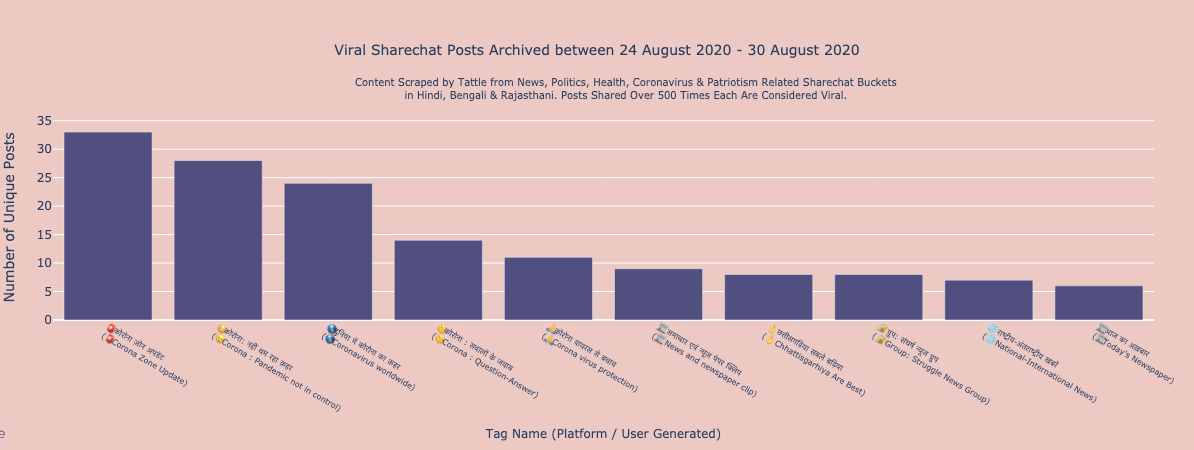

In [889]:
fig = go.Figure(
    data=[go.Bar(x=xticks,
        y=pop["tag_name"].value_counts()[:10])],
    layout=go.Layout(
        title=go.layout.Title(text="Viral Sharechat Posts Archived between 24 August 2020 - 30 August 2020",
                              x=0.5,
                              y=0.9,
                              yanchor="top",
                              font={"size":14}),
        plot_bgcolor="#EDC9C4",
        paper_bgcolor="#EDC9C4",
        colorway=["#514E80"],
        width=600,
        height=450,
        autosize=False,
        margin={"l":40, "r":40, "t":115, "b":40}
    )
)
fig.update_yaxes(range=[0,36], dtick=5)

fig.add_layout_image(dict(
                         source="https://raw.githubusercontent.com/tattle-made/sharechat-scraper/master/logo_name_blue.png",
                         xref="paper",
                         yref="paper",
                         x=-0.1,
                         y=-0.6,
                         sizex=0.1, 
                         sizey=0.1,
                         xanchor="left", 
                         yanchor="bottom"))
fig.update_layout(yaxis_title="Number of Unique Posts", xaxis_title={"text":"Tag Name (Platform / User Generated)",
                                                             "font":{"size":12}})

fig.update_xaxes(tickfont=dict(size=8))


fig.update_layout(annotations=[
       go.layout.Annotation(
           xref="paper",
           yref="paper",
            showarrow=False,
            text="Content Scraped by Tattle from News, Politics, Health, Coronavirus & Patriotism Related Sharechat Buckets<br>"+"in Hindi, Bengali & Rajasthani. Posts Shared Over 500 Times Each Are Considered Viral.",
            x=0.52,
            y=1.2,
            font=dict(
                size=10,
            )
        )])

fig.add_annotation(
           xref="paper",
           yref="paper",
            text="tattle.co.in",
            showarrow=False,
            x=1.14,
            y=-0.62,
            font=dict(
                size=9,
            ))

fig.show()

In [890]:
fig.write_image("viraltags31082020.png", width=600,height=450,scale=10)

## Scraper type

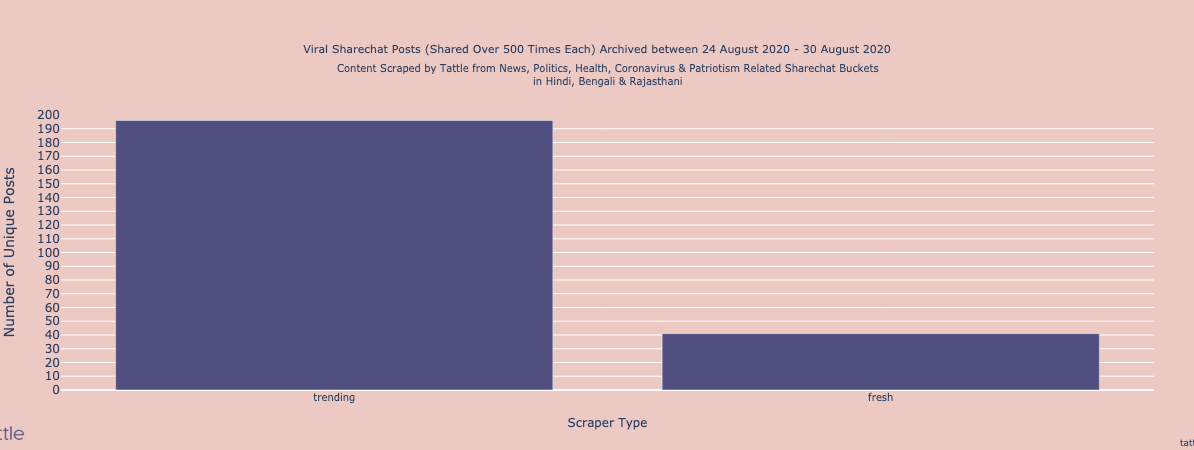

In [775]:
fig = go.Figure(
    data=[go.Bar(x=pop["scraper_type"].value_counts()[:10].index,
        y=pop["scraper_type"].value_counts()[:10])],
    layout=go.Layout(
        title=go.layout.Title(text="Viral Sharechat Posts (Shared Over 500 Times Each) Archived between 24 August 2020 - 30 August 2020",
                              x=0.5,
                              y=0.9,
                              yanchor="top",
                              font={"size":11}),
        plot_bgcolor="#EDC9C4",
        paper_bgcolor="#EDC9C4",
        colorway=["#514E80"],
        width=600,
        height=450,
        autosize=False,
        margin={"l":40, "r":40, "t":115, "b":60}
    )
)
fig.update_yaxes(range=[0,200], dtick=10)

fig.add_layout_image(dict(
                         source="https://raw.githubusercontent.com/tattle-made/sharechat-scraper/master/logo_name_blue.png",
                         xref="paper",
                         yref="paper",
                         x=-0.11,
                         y=-0.205,
                         sizex=0.1, 
                         sizey=0.1,
                         xanchor="left", 
                         yanchor="bottom"))
fig.update_layout(yaxis_title="Number of Unique Posts", xaxis_title={"text":"Scraper Type",
                                                             "font":{"size":12}})

fig.update_xaxes(tickfont=dict(size=10))


fig.update_layout(annotations=[
       go.layout.Annotation(
           xref="paper",
           yref="paper",
            showarrow=False,
            text="Content Scraped by Tattle from News, Politics, Health, Coronavirus & Patriotism Related Sharechat Buckets<br>"+"in Hindi, Bengali & Rajasthani",
            x=0.5,
            y=1.2,
            font=dict(
                size=10,
            )
        )])

fig.add_annotation(
           xref="paper",
           yref="paper",
            text="tattle.co.in",
            showarrow=False,
            x=1.07,
            y=-0.215,
            font=dict(
                size=9,
            ))

fig.show()

In [776]:
fig.write_image("viralscrapers31082020.png", width=600,height=450,scale=10)

## Word clouds

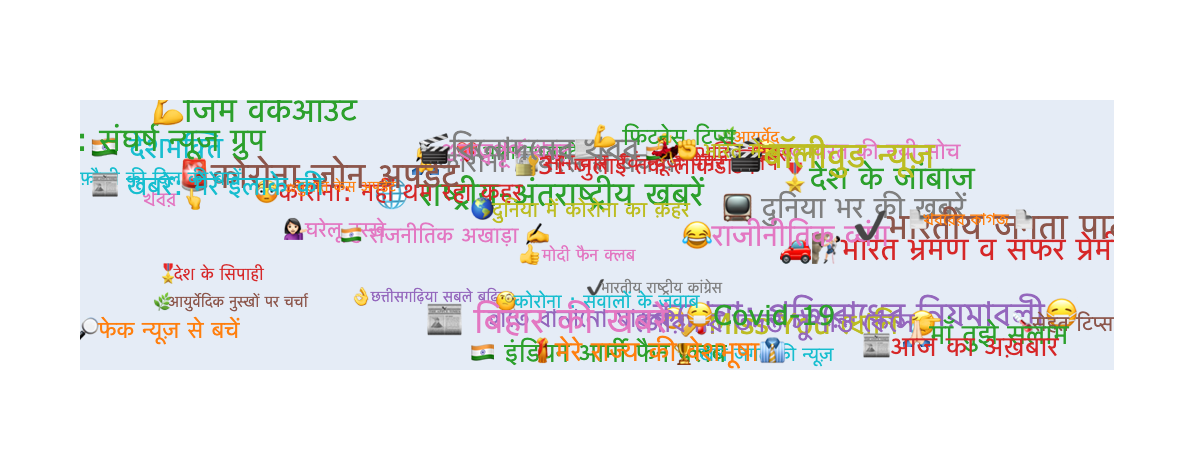

In [486]:
words = df["tag_name"].value_counts()[:50].index
#n = df["tag_name"].nunique()
n=50
colors = [plotly.colors.DEFAULT_PLOTLY_COLORS[random.randrange(1, 10)] for i in range(n)]
#weights = df["tag_name"].value_counts()[:5]
weights = [random.randint(15, 35) for i in range(n)]
data = go.Scatter(x=[random.random() for i in range(n)],
                 y=[random.random() for i in range(n)],
                 mode='text',
                 text=words,
                 marker={'opacity': 0.3},
                 textfont={'size': weights,
                           'color': colors})
layout = go.Layout({'xaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False},
                    'yaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False}})
fig = go.Figure(data=[data], layout=layout)

fig.show()

In [477]:
fig.write_image("sample-tags.png",height=800,width=800,scale=10)

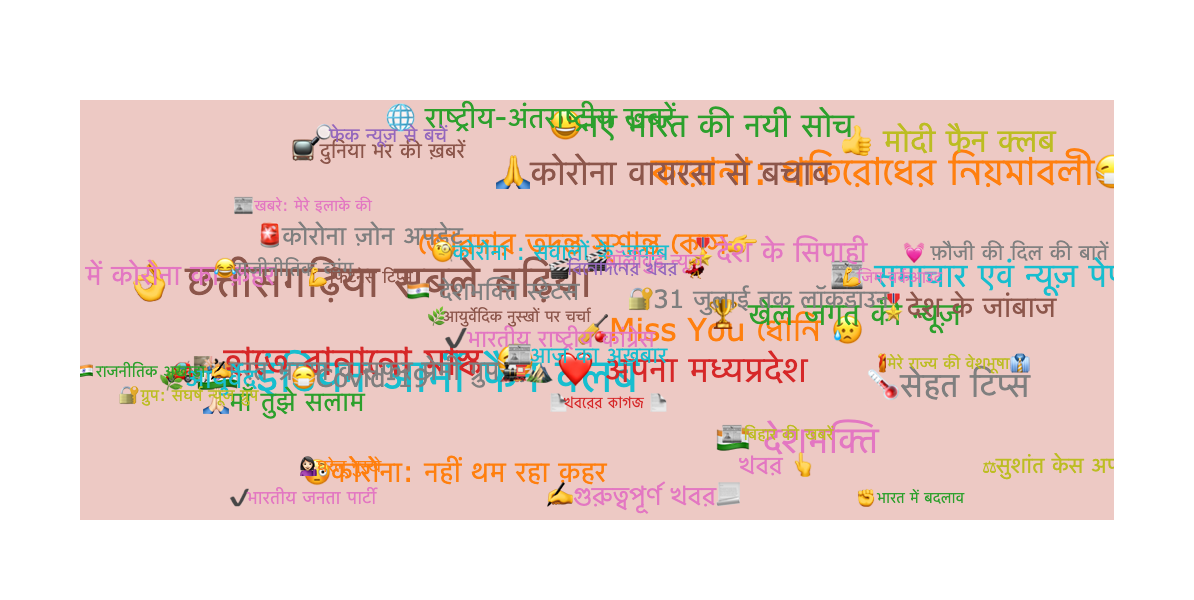

In [535]:
words = df["tag_name"].value_counts()[:50].index
frequency = df["tag_name"].value_counts()[:50]
lower, upper = 15, 45
frequency = [((x - min(frequency)) / (max(frequency) - min(frequency))) * (upper - lower) + lower for x in frequency]
length = len(words)
colors = [plotly.colors.DEFAULT_PLOTLY_COLORS[random.randrange(1, 10)] for i in range(length)]

data = go.Scatter(
#x=list(range(length)),
x=random.choices(range(length), k=length),
y=random.choices(range(length), k=length),
mode='text',
text=words,
hovertext=['{0}{1}'.format(w, f) for w, f in zip(words, frequency)],
hoverinfo='text',
textfont={'size': frequency, 'color': colors})
layout = go.Layout({'xaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False},
                    'yaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False}},
                  height=600,width=800,
                  plot_bgcolor="#EDC9C4")

fig = go.Figure(data=[data], layout=layout)
fig.show()

In [583]:
hindi_df = df[df["language"] == "Hindi"]
values = list(hindi_df["tag_name"].value_counts())
keys = list(hindi_df["tag_name"].value_counts().index)
freqs = dict(zip(keys,values))

In [549]:
font_path = path.join("Lohit-Devanagari.ttf",
                     "Lohit-Bengali.ttf")

In [611]:
emoji = "['\U0001F300-\U0001F5FF'|'\U0001F600-\U0001F64F'|'\U0001F680-\U0001F6FF'|'\u2600-\u26FF\u2700-\u27BF'|'\U0001F1EE,\U0001F1F3'|'\U0001F9D7'|'\U0001F9D0'|'\U0001F917'|'\U0001F9D8'|'\U0001F9B1'|'\U0001F913'|'\U0001F92B']"

In [612]:
#non_hindi = "^[\u0900-\u097F]"

In [588]:
keys= [re.sub(non_hindi,"", i)  for i in keys]

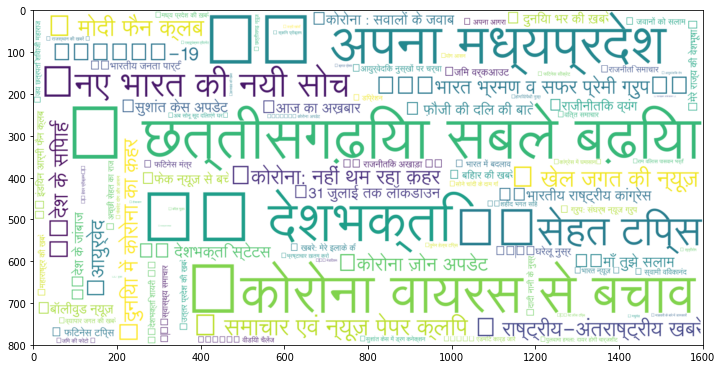

In [574]:
wordcloud = WordCloud(width=1600,height=800, font_path="Lohit-Devanagari.ttf", 
                      relative_scaling=0.5, background_color="white").generate_from_frequencies(freqs)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

## Emojis

In [646]:
def emoji_counter(data):
    text = " ".join(data)
    emoji = "['\U0001F300-\U0001F5FF'|'\U0001F600-\U0001F64F'|'\U0001F1EE\U0001F1F3'|'\u2600-\u26FF\u2700-\u27BF'|'\U0001F1EE, \U0001F1F3'|'\U0001F9D7'|'\U0001F9D0'|'\U0001F917'|'\U0001F9D8'|'\U0001F9B1'|'\U0001F913'|'\U0001F92B']"
    # Find emojis
    emojis = regexp_tokenize(text, emoji)
    emoji_string = "".join(emojis)
    # Find emojis that contain two codepoints
    #char_with_modifier = re.compile(r'(.[\U0001f3fb-\U0001f3ff]?)')
    char_with_modifier = re.compile(r'(.[\U0001F1F3]?)')
    x = Counter(char_with_modifier.findall(emoji_string))
    return x.most_common()

In [647]:
emojis = emoji_counter(df["tag_name"].unique())
print(emojis)

[(' ', 670), ('📰', 16), ('🙏', 14), ('🏻', 9), ('🇮🇳', 8), ('👉', 8), ('🎂', 6), ('😷', 5), ('😥', 5), ('🗞', 4), ('🧘', 4), ('💪', 4), ('🤗', 4), ('📱', 4), ('📺', 3), ('🔐', 3), ('🎬', 3), ('✍', 3), ('👩', 3), ('⚕', 3), ('🌿', 3), ('😔', 3), ('♂', 3), ('🏏', 3), ('💐', 3), ('✔', 2), ('😳', 2), ('🧐', 2), ('🌡', 2), ('🦱', 2), ('👨', 2), ('💉', 2), ('😑', 2), ('😃', 2), ('🎖', 2), ('🙅', 2), ('😎', 2), ('❤', 2), ('😲', 2), ('👆', 2), ('⚽', 2), ('📃', 2), ('☪', 2), ('📄', 2), ('📈', 2), ('✋', 2), ('💴', 2), ('👤', 2), ('👀', 2), ('❌', 2), ("'", 2), ('👍', 1), ('🏆', 1), ('🌐', 1), ('😂', 1), ('🔎', 1), ('📝', 1), ('💰', 1), ('⚖', 1), ('🌎', 1), ('💁', 1), ('♀', 1), ('🙂', 1), ('🤓', 1), ('📸', 1), ('🤫', 1), ('🔖', 1), ('🌼', 1), ('🖊', 1), ('💓', 1), ('👌', 1), ('✊', 1), ('🧗', 1), ('⛰', 1), ('👔', 1), ('📞', 1), ('😱', 1), ('😀', 1), ('🗣', 1), ('⛽', 1), ('😊', 1), ('😵', 1), ('📢', 1), ('☺', 1), ('💃', 1), ('😠', 1), ('🙋', 1), ('🙄', 1), ('❓', 1), ('❗', 1), ('🕺', 1), ('🎥', 1), ('🌟', 1), ('😨', 1), ('😟', 1), ('⛈', 1), ('🐶', 1), ('🐕', 1), ('📩', 1), ('🍌'

In [648]:
emoji_dict = dict(emojis)
key = emoji_dict.keys()
emoji_df = pd.DataFrame(emojis,index=key)

In [672]:
# Clean up the emojis dataframe
emoji_df.reset_index(inplace = True, drop = True)
# Merge identical emojis
#emoji_df[1][1] = (emoji_df[1][1] + emoji_df[1][9])
# Drop non-emoji characters
emoji_df.drop(index = [0,3], inplace = True)
emoji_df.reset_index(drop = True, inplace = True)
# Separate the top 10 emojis 
emoji_df_20 = emoji_df[:10]

In [673]:
# Save emojis and their frequencies for plotting
em = emoji_df_20[0]
freq = emoji_df_20[1]

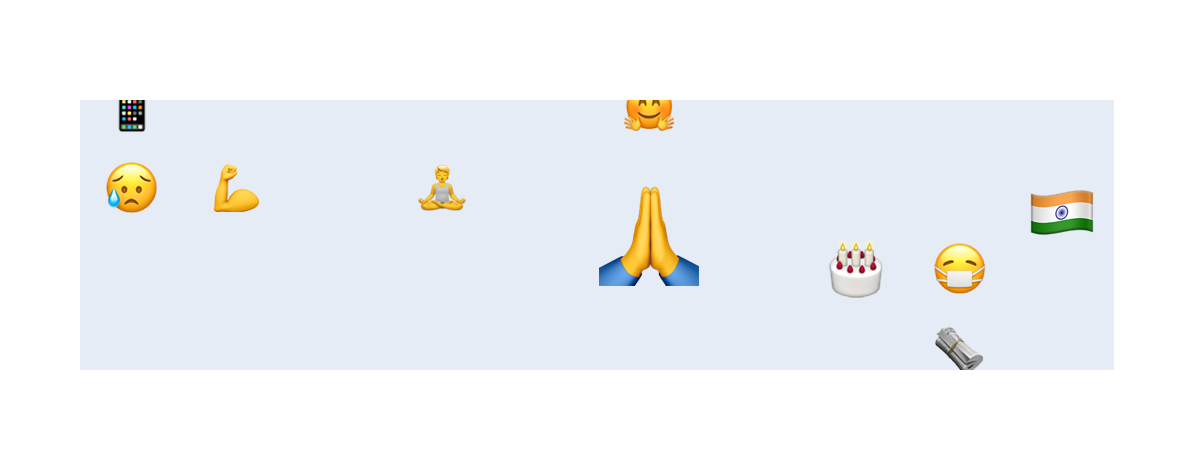

In [684]:
words = em
frequency = freq
lower, upper = 50, 100
frequency = [((x - min(frequency)) / (max(frequency) - min(frequency))) * (upper - lower) + lower for x in frequency]
length = len(words)
colors = [plotly.colors.DEFAULT_PLOTLY_COLORS[random.randrange(1, 10)] for i in range(length)]

data = go.Scatter(
x=random.choices(range(length), k=length),
y=random.choices(range(length), k=length),
mode='text',
text=words,
hovertext=['{0}{1}'.format(w, f) for w, f in zip(words, freq)],
hoverinfo='text',
textfont={'size': frequency, 'color': colors})
layout = go.Layout({'xaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False},
                    'yaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False}})

fig = go.Figure(data=[data], layout=layout)
fig.show()

## Viral posts

In [1012]:
end = datetime.utcnow() - timedelta(days=2)
start = end - timedelta(days=7)
print(start)
print(end)

2020-08-24 09:54:13.229530
2020-08-31 09:54:13.229530


In [1052]:
# Convert virality metric fields to numeric & filter
def get_viral(coll):
    pipeline = [
        {"$project":{"post_permalink": "$post_permalink", "s3_url":"$s3_url", "language":"$language",
                     "tag_name":"$tag_name","tag_translation": "$tag_translation", "tag_genre":"$tag_genre", "bucket_name": "$bucket_name",
                     "bucket_id": "$bucket_id", 
#                     "scraped_date": {"$dateToString": {"date": "$scraped_date"}},
                    "scraped_date": "$scraped_date",
                     "shares": {"$toInt": "$external_shares"}}},
        {"$match": {"scraped_date":{"$gte": start, "$lte": end}, "shares": {"$gte": 500}, "post_permalink": "https://sharechat.com/post/q91Jpzr"}}]
    
    docs = coll.aggregate(pipeline)
    c=0
    for i in docs:
        c+=1
        print(i)
    print(c)
    return docs

In [1053]:
docs= get_viral(coll)

{'_id': ObjectId('5f498cf9c01d70bcb14854e3'), 'post_permalink': 'https://sharechat.com/post/q91Jpzr', 's3_url': 'https://s3.ap-south-1.amazonaws.com/sharechat-scraper.tattle.co.in/7e1e9fbb-0d91-4ceb-b806-aeab5389f0e3.jpg', 'language': 'Hindi', 'tag_name': '📰 समाचार एवं न्यूज़ पेपर क्लिप', 'tag_translation': '📰 News and newspaper clip', 'tag_genre': 'News', 'bucket_name': 'ख़बरें और राजनीति', 'bucket_id': 125, 'scraped_date': datetime.datetime(2020, 8, 28, 22, 28, 25, 748000), 'shares': 2451}
1
